# MBA em Ciência de Dados
# Técnicas Avançadas de Captura e Tratamento de Dados


### <span style="color:darkred">Módulo II - Tratamento e Limpeza de Dados
</span>


### <span style="color:darkred">Tratamento de desbalanceamento: subamostragem e aumentação de dados</span>

Material Produzido por Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from imblearn import over_sampling
from imblearn import under_sampling
from imblearn import combine

# Dados Desbalanceados

Vamos estudar o problema de dados desbalanceados utilizando o conjunto de dados de natalidade em uma maternidade.

In [3]:
data = pd.read_csv("../dados/TACTD_01-BCE_Outliers_Err_Desbal.csv")
data.head()

,Sex,Weight,Gestational age,Month,Year
0,F,3490,38,11,2016
1,M,3650,39,11,2016
2,M,2740,34,11,2016
3,F,3380,39,12,2016
4,F,3820,38,12,2016


In [4]:
data['Sex'].value_counts()

F    53
M    18
P     1
Name: Sex, dtype: int64

In [4]:
data.loc[data['Sex'] == 'P', 'Sex'] = np.nan

In [5]:
data[data['Sex'].isnull()]

,Sex,Weight,Gestational age,Month,Year
16,NaN,3600,36,1,2017


In [6]:
data['Sex'].value_counts()

F    53
M    18
Name: Sex, dtype: int64

In [5]:
prop_F = data['Sex'].describe()['freq']/data['Sex'].describe()['count']
print("%.2f%%" % (prop_F*100))

73.61%


Nesse caso temos um desbalanceamento de aproximadamente 1:4

Ao inferir modelos temos que tratar a amostra relativa ao Sexo Feminino e ao Sexo Masculino de forma a controlar por essa diferença.

Em alguns métodos de aprendizado, por exemplo, a quantidade de dados é levada em consideração e pode trazer um peso maior para a categoria chamada de *majoritária*, nesse caso o sexo Feminino.


O efeito de desbalanceamento pode causar o deslocamento de uma superfície de decisão aprendida, favorecendo a classe majoritária

<img src="../imagens/desb_1_deci.png" width=280>

---



# Métodos de tratamento de desbalanceamento

1. **Subamostragem**: remove exemplos da classe majoritária
2. **Aumentação de dados/sobreamostragem**: cria *novos* exemplos sintéticos/artificiais para a classe minoritária

### Subamostragem aleatória

<img src="../imagens/desb_2_unders.png" width=400>


### SMOTE

Método de sobreamostragem *Synthetic Minority Oversampling Technique*

<img src="../imagens/desb_3_SMOTE.png" width=600>

### TomekLinks

Método de remoção de exemplos com base no vizinho mais próximo

<img src="../imagens/desb_4_tomek.png" width=600>

### Edited Nearest Neighbors (ENN)

Utiliza $k$ vizinhos mais próximos ao invés de um único como no Tomek

---

Vamos utilizar uma base de dados desbalanceada para mostrar alguns métodos

In [8]:
# https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent
data = pd.read_csv("../dados/houses_to_rent_mba_nomissing2.csv")

# tratamento de dados
data_nred = data.drop_duplicates(keep='first').copy()
data_nred.loc[data_nred['floor']=='-','floor'] = '0'
data_nred.loc[:,'floor'] = pd.to_numeric(data_nred['floor'], downcast='integer', errors='coerce')
data_nred.loc[:,'tax'] = pd.to_numeric(data_nred['tax'], downcast='float', errors='coerce')
data_nred = data_nred.dropna()

In [10]:
# remoção de outliers
def remove_outliers(df, attributes, factor=2):
    for var in attributes:
        # verifica se variável é numerica
        if np.issubdtype(df[var].dtype, np.number):
            Q1 = df[var].quantile(0.25)
            Q2 = df[var].quantile(0.25)
            Q3 = df[var].quantile(0.75)
            IQR = Q3 - Q1
        
        # apenas inliers segundo IQR
        df = df.loc[(df[var] >= Q1-(IQR*factor)) & (df[var] <= Q3+(IQR*factor)), :]
    return df

attributes = ['tax','insurance', 'hoa', 'rent']
data_out = remove_outliers(data_nred, attributes)

print("Antes: %d, Depois tratamento: %d" % (data_nred.shape[0], data_out.shape[0]))

Antes: 10695, Depois tratamento: 8811


Vamos separar essa base de dados em conjuntos de treinamento (X) e teste (Z)

In [11]:
frac_trein = 0.8
dtrain = data.sample(frac=frac_trein, random_state=1)
dtest = data.drop(dtrain.index)

Agora vamos treinar:
1. classificador para predizer a **cidade** com base no imposto, valor do condomínio e valor do seguro, e valor do condomínio

In [12]:
# Treinando classificador
X = dtrain[['tax','insurance', 'hoa']]
Y = dtrain['city']

ZX = dtest[['tax','insurance', 'hoa']]
ZY = dtest['city']

clf = SVC(gamma='auto')
clf.fit(X,Y)
ZY_ = clf.predict(ZX)

In [13]:
acc_base = metrics.accuracy_score(ZY, ZY_)
accb_base = metrics.balanced_accuracy_score(ZY, ZY_)
print("Acurácia: %0.2f" % (acc_base*100))
print("Acurácia balanceada: %0.2f" % (accb_base*100))

Acurácia: 61.79
Acurácia balanceada: 28.88


<AxesSubplot:>

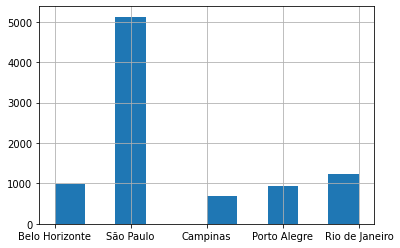

In [14]:
dtrain['city'].hist()

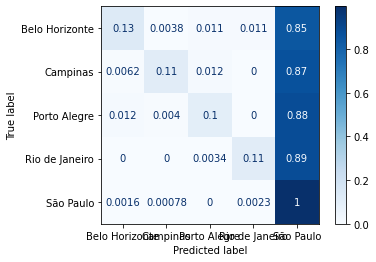

In [15]:
disp = plot_confusion_matrix(clf, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

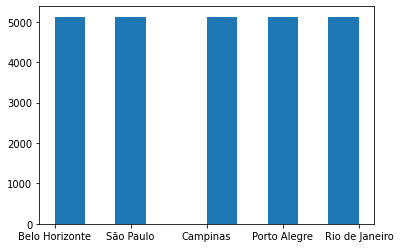

In [16]:
oversamp = over_sampling.SMOTE() # sampling_strategy pode ser usado para casos binários
Xo, Yo = oversamp.fit_resample(X, Y)
h = plt.hist(Yo)

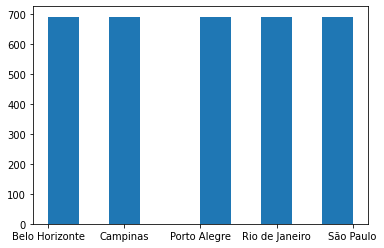

In [17]:
undersamp = under_sampling.RandomUnderSampler()
Xu, Yu = undersamp.fit_resample(X, Y)

h = plt.hist(Yu)

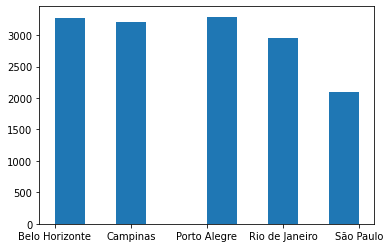

In [18]:
overunder = combine.SMOTEENN(sampling_strategy='all')
Xc, Yc = overunder.fit_resample(X, Y)

h = plt.hist(Yc)

In [19]:
clf_ov = SVC(gamma='auto')
clf_ov.fit(Xo,Yo)
ZYov_ = clf_ov.predict(ZX)

clf_un = SVC(gamma='auto')
clf_un.fit(Xu,Yu)
ZYun_ = clf_un.predict(ZX)

clf_co = SVC(gamma='auto')
clf_co.fit(Xc,Yc)
ZYco_ = clf_co.predict(ZX)

In [20]:
accb_ov = metrics.balanced_accuracy_score(ZY, ZYov_)
accb_un = metrics.balanced_accuracy_score(ZY, ZYun_)
accb_co = metrics.balanced_accuracy_score(ZY, ZYco_)
print("Acurácia balanceada base: %0.3f" % (accb_base))
print("- oversampling (SMOTE): %0.3f" % (accb_ov))
print("- undersampling: %0.3f" % (accb_un))
print("- oversampling + undersampling (SMOTEENN): %0.3f" % (accb_co))

Acurácia balanceada base: 0.289
- oversampling (SMOTE): 0.357
- undersampling: 0.331
- oversampling + undersampling (SMOTEENN): 0.339


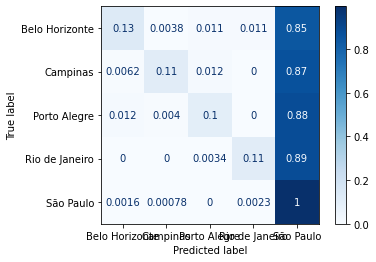

In [21]:
disp = plot_confusion_matrix(clf, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

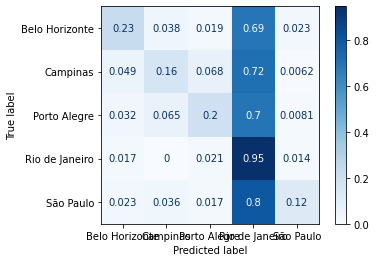

In [22]:
disp = plot_confusion_matrix(clf_un, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

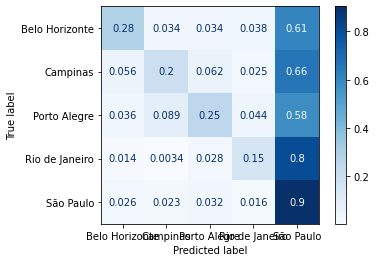

In [23]:
disp = plot_confusion_matrix(clf_ov, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

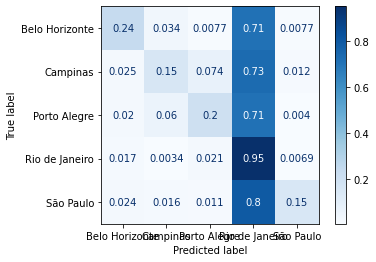

In [24]:
disp = plot_confusion_matrix(clf_co, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

### Resumo

* desbalanceamento também pode ser um problema relevante em bases de dados reais
* ganhos significativos podem ser obtidos por meio de métodos de amostragem
